In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:

""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2



### Epipolar Geometry

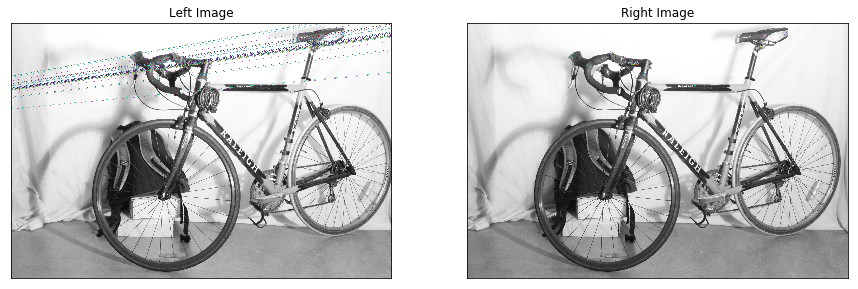

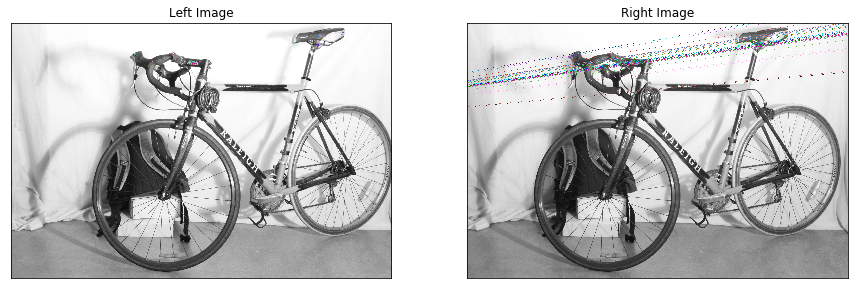

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in ubyte_scalars


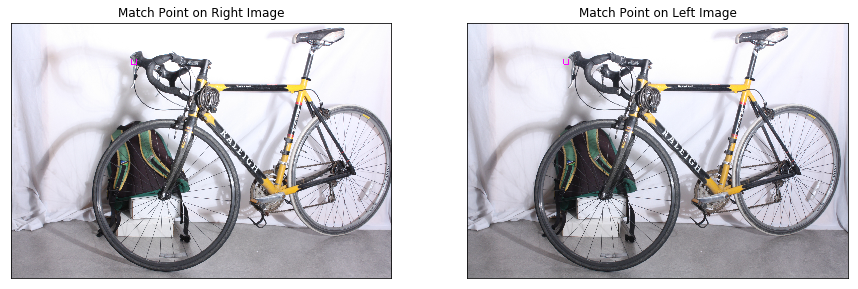

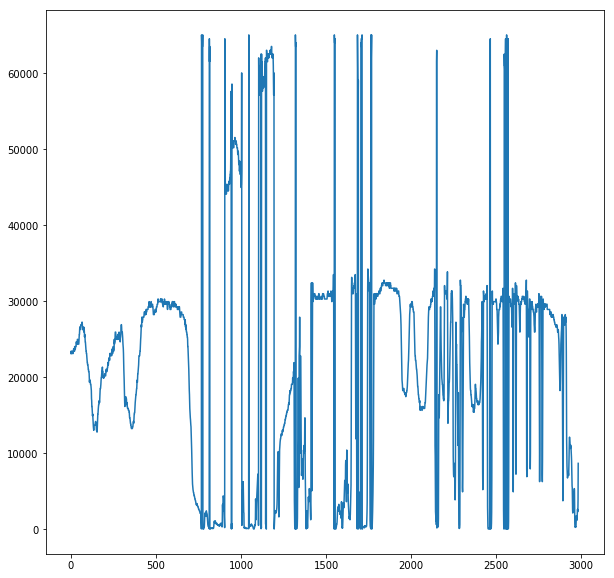

In [4]:

# load left and right images
imgL = cv2.imread('./Bicycle1-perfect/im0.png',cv2.IMREAD_GRAYSCALE);
imgR = cv2.imread('./Bicycle1-perfect/im1.png',cv2.IMREAD_GRAYSCALE);

# create a sift object
sift = cv2.xfeatures2d.SIFT_create()

# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2)

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)
        
# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL[:50], ptsL[:50], ptsR[:50])

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR[:50], ptsR[:50], ptsL[:50])


# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()


# create the 5x5 patch
patch = imgR[ptsR[25][1]-3:ptsR[25][1]+2,ptsR[25][0]-3:ptsR[25][0]+2]

# find the epipolar line
epiline = imgL[ptsR[25][0]-3:ptsR[25][0]+2,:]
total_error = 0
errorArray = []

# compare the patch on epipolar line
for idx in range(0,epiline.shape[1]-4,1):
    for col in range(0,5,1):
        for row in range(idx,idx+5,1):
            error = np.power(epiline[col,row]-patch[col,row-idx],2)
            total_error = total_error + error
    errorArray.append(error)
    total_error = 0
    
minError = np.argmin(errorArray)

# load display images
imgR = cv2.imread('./Bicycle1-perfect/im0.png')
imgL = cv2.imread('./Bicycle1-perfect/im1.png')

imgR_disp = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)
imgL_disp = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)

# draw the matchpoints on right and left images
cv2.rectangle(imgR_disp, (ptsR[25][0]-20,ptsR[25][1]-20), (ptsR[25][0]+20, ptsR[25][1]+20), (255,0,255), 5)
cv2.rectangle(imgL_disp, (minError-20,ptsR[25][1]-20), (minError+20, ptsR[25][1]+20), (255,0,255), 5)

plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgR_disp)
plt.title("Match Point on Right Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgL_disp)
plt.title("Match Point on Left Image"), plt.xticks([]), plt.yticks([])
plt.show()

# Plot SSD
plt.figure(figsize=(10,10))
plt.plot(errorArray)

### Reasoning Questions
#### 1. Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one? Explain why.

One matching point is found and it is really close to the correct one. The sum of squared difference method finds the matching patch by finding the patch with smallest error and minimal error usually indicates the right solution so this method will maximize the chance of finding the correct match point. 

#### 2. Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single match?

We can minimize the search region. Instead of scanning the entire epipolar line, we can set the search region to be just the left/right or middle. 

#### 3. Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match?

We can try to have a smaller search window so the influence of the surrounding pixels will be minimized and the search criteria is also more strict.